# High-Dimensional-Deep-Learning
### Mini-project n° 4– RNN, LSTM and GRU vs MLP and CNN

###  Maddie Perez, Julia Soufflet, Maïmouna Gadji et Phuc-Luan Nguyen

L'objectif de ce mini-projet est de comparer un RNN, un LSTM et un GRU, ainsi que les modèles plus traditionnels comme le MLP et le CNN, sur le dataset IMDB pour la tâche d'analyse de sentiments. Cela signifie qu'à partir des commentaires sur les films dans le dataset IMDB, nous cherchons à construire un modèle capable d'évaluer si un commentaire est positif ou négatif.

Pour réaliser la comparaison entre ces modèles, il est nécessaire d'expliquer et d'évaluer :

+ Le choix des architectures : les types de couches, les tailles des couches et les fonctions d'activation.
+ Le choix des hyperparamètres : taille des lots (batch size), taux d'apprentissage (learning rate), nombre d'époques (epochs).
+ Le choix de la fonction de perte (loss function).
+ Comparer le temps d'exécution des différents modèles et leur précision.


## I. Importation des données

In [1]:
import os
import pandas as pd

In [2]:
# Définir le chemin du dossier principal contenant les données
base_dir = 'IMDB_dataset' 

# Initialiser les DataFrames vides pour les ensembles d'entraînement, de test et non étiquetés
train_df = pd.DataFrame(columns=["text", "label"])
test_df = pd.DataFrame(columns=["text", "label"])
unlabeled_data = pd.DataFrame(columns=["text"])

# Parcourir les dossiers train et test pour charger les fichiers étiquetés
for folder in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        # Créer le chemin complet pour chaque dossier (pos/neg)
        sentiment_folder = os.path.join(base_dir, folder, sentiment)
        
        # Initialiser une liste pour stocker les données de chaque dossier
        texts = []
        labels = []
        
        # Parcourir tous les fichiers .txt dans le dossier
        for filename in os.listdir(sentiment_folder):
            if filename.endswith('.txt'):
                # Créer le chemin complet du fichier
                file_path = os.path.join(sentiment_folder, filename)
                
                # Ouvrir le fichier et lire son contenu
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()  # Lire tout le contenu du fichier
                
                # Ajouter le texte et l'étiquette correspondante à la liste
                texts.append(text)
                labels.append(1 if sentiment == 'pos' else 0)  # 1 pour positif, 0 pour négatif
        
        # Créer un DataFrame pour le dossier actuel
        temp_df = pd.DataFrame({"text": texts, "label": labels})
        
        # Ajouter les données au DataFrame d'entraînement ou de test
        if folder == 'train':
            train_df = pd.concat([train_df, temp_df], ignore_index=True)
        elif folder == 'test':
            test_df = pd.concat([test_df, temp_df], ignore_index=True)

# Traiter les données non étiquetées dans le dossier 'train/unsup'
unsup_folder = os.path.join(base_dir, 'train', 'unsup')

# Initialiser une liste pour les textes non étiquetés
unlabeled_texts = []

# Parcourir tous les fichiers .txt dans le dossier unsup
for filename in os.listdir(unsup_folder):
    if filename.endswith('.txt'):
        # Créer le chemin complet du fichier
        file_path = os.path.join(unsup_folder, filename)
        
        # Ouvrir le fichier et lire son contenu
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()  # Lire tout le contenu du fichier
        
        # Ajouter le texte à la liste des données non étiquetées
        unlabeled_texts.append(text)

# Créer un DataFrame pour les données non étiquetées
unlabeled_data = pd.DataFrame({"text": unlabeled_texts})

In [3]:
## Sauvegarde des DataFrames en CSV
#train_df.to_csv("train_data.csv", index=False, encoding='utf-8')
#test_df.to_csv("test_data.csv", index=False, encoding='utf-8')
#unlabeled_data.to_csv("unlabeled_data.csv", index=False, encoding='utf-8')


In [2]:
# Chargement des DataFrames depuis un fichier CSV
train_df = pd.read_csv("train_data.csv", encoding='utf-8')
test_df = pd.read_csv("test_data.csv", encoding='utf-8')
unlabeled_data = pd.read_csv("unlabeled_data.csv", encoding='utf-8')


## II. Prétraitement des données

### II. 1. Exploitation des données

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Vérifier la taille des DataFrames et afficher le nombre de "pos" et "neg"
print(f"Nombre d'exemples dans le train set : {train_df.shape[0]}")  # Nombre d'exemples d'entraînement
print(f"Nombre d'exemples dans le test set : {test_df.shape[0]}")    # Nombre d'exemples de test
print(f"Nombre d'exemples non étiquetés dans le train/unsup : {unlabeled_data.shape[0]}")  # Nombre de données non étiquetées

Nombre d'exemples dans le train set : 25000
Nombre d'exemples dans le test set : 25000
Nombre d'exemples non étiquetés dans le train/unsup : 50000


In [4]:
train_df.head()

,text,label
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [5]:
unlabeled_data.head()

,text
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


In [6]:
# Vérification des valeurs nulles
print("\nVérification des valeurs nulles dans le train set :")
print(train_df.isnull().sum())  # Compte les valeurs nulles dans chaque colonne

print("\nVérification des valeurs nulles dans le test set :")
print(test_df.isnull().sum())  # Compte les valeurs nulles dans chaque colonne

print("\nVérification des valeurs nulles dans les données non étiquetées :")
print(unlabeled_data.isnull().sum())  # Compte les valeurs nulles dans chaque colonne


Vérification des valeurs nulles dans le train set :
text     0
label    0
dtype: int64

Vérification des valeurs nulles dans le test set :
text     0
label    0
dtype: int64

Vérification des valeurs nulles dans les données non étiquetées :
text    0
dtype: int64


In [7]:
# Vérification des doublons
print("\nVérification des doublons dans le train set :")
print(train_df.duplicated().sum())  # Nombre de lignes dupliquées dans le train set

print("\nVérification des doublons dans le test set :")
print(test_df.duplicated().sum())  # Nombre de lignes dupliquées dans le test set

print("\nVérification des doublons dans les données non étiquetées :")
print(unlabeled_data.duplicated().sum())  # Nombre de lignes dupliquées dans les données non étiquetées

# Extraire les textes de l'ensemble train et test
train_texts = train_df["text"]
test_texts = test_df["text"]

# Trouver l'intersection entre les deux ensembles de textes (train et test)
common_texts = set(train_texts).intersection(set(test_texts))

# Afficher le nombre d'éléments communs (intersection)
print(f"\nNombre de commentaires communs entre l'ensemble train et l'ensemble test : {len(common_texts)}")


Vérification des doublons dans le train set :
96

Vérification des doublons dans le test set :
199

Vérification des doublons dans les données non étiquetées :
493

Nombre de commentaires communs entre l'ensemble train et l'ensemble test : 123


In [8]:
# Supprimer les doublons dans train et test
train_df = train_df.drop_duplicates(subset=["text"])
test_df = test_df.drop_duplicates(subset=["text"])
unlabeled_data = unlabeled_data.drop_duplicates(subset=["text"])

# Trouver l'intersection
common_texts = set(train_df["text"]).intersection(set(test_df["text"]))

# Supprimer les commentaires communs dans les deux ensembles
test_df = test_df[~test_df["text"].isin(common_texts)]

# Afficher les tailles après nettoyage
print(f"Train set size after cleaning: {train_df.shape[0]}")
print(f"Test set size after cleaning: {test_df.shape[0]}")

Train set size after cleaning: 24904
Test set size after cleaning: 24678


In [9]:
train_df['label'] = train_df['label'].astype('category')
test_df['label'] = test_df['label'].astype('category')

### II. 2. Division des données 

In [10]:
from sklearn.model_selection import train_test_split

# Diviser les données d'entraînement en train et validation
train_df,val_df = train_test_split(train_df, test_size=0.15, random_state=42)


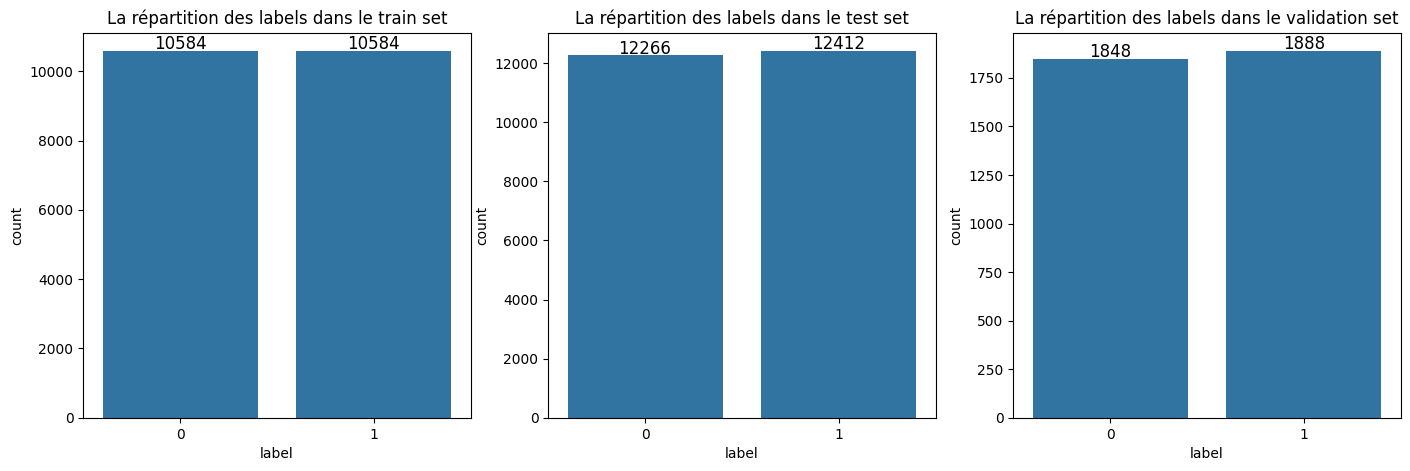

In [11]:
plt.figure(figsize=(17,5))
# Train set
plt.subplot(131)
ax1 = sns.countplot(x=train_df["label"])
plt.title("La répartition des labels dans le train set")
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Test set
plt.subplot(132)
ax2 = sns.countplot(x=test_df["label"])
plt.title("La répartition des labels dans le test set")
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Validation set
plt.subplot(133)
ax3 = sns.countplot(x=val_df["label"])
plt.title("La répartition des labels dans le validation set")
for p in ax3.patches:
    ax3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


### II. 3. Représentation du texte

In [12]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

#Appliquer TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)  # Limit to 3000 features
train_tfidf = vectorizer.fit_transform(train_df["text"])
val_tfidf=vectorizer.transform(val_df["text"])
test_tfidf = vectorizer.transform(test_df["text"])


### Essai Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(train_tfidf, train_df['label'])

train_score = model.score(train_tfidf,train_df['label'] )
print(train_score)

0.904572940287226


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12266
           1       0.87      0.88      0.88     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678

Confusion Matrix:


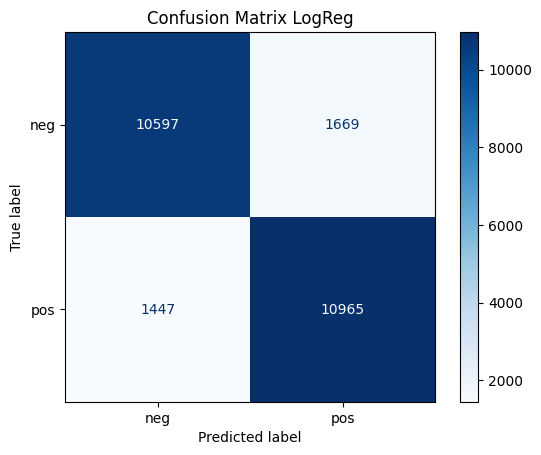

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur les données de test
y_pred = model.predict(test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(test_df["label"], y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Rapport de classification
print("Classification Report:")
print(classification_report(test_df["label"], y_pred))

# Matrice de confusion
print("Confusion Matrix:")
cm = confusion_matrix(test_df["label"], y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix LogReg")
plt.show()

## III. Modélisation

**Sur le choix des architectures :**
+ Les types de couches (layer types) :

        Nous avons choisi les types de couches correspondants aux modèles que nous souhaitons utiliser (RNN, LSTM, GRU, MLP, CNN). En outre, nous avons ajouté des couches de dropout pour éviter le surapprentissage (overfitting).
+ La taille des couches (layer size) :

        Nous avons testé avec 32, 64 et 128 neurones. Nous avons constaté que la précision avec 128 neurones était meilleure (ce qui est assez évident car le modèle est plus complexe). De plus, le temps d'entraînement avec 128 neurones reste raisonnable, ce qui justifie notre choix de cette taille.
        Nous avons décidé d'utiliser 128 neurones pour les modèles RNN, LSTM et GRU afin de pouvoir comparer leur temps d'exécution.
+ Les fonctions d'activation (activations) :

        La couche de sortie utilise une fonction d'activation sigmoïde pour les tâches de classification binaire (sentiment positif ou négatif).

**Sur le choix des hyperparamètres :**

+ Batch size et taux d'apprentissage (learning rate) :

        Nous testerons sur différentes valeurs pour trouver les hyperparamètres les plus adaptés et l'appliquerons à tous les modèles afin de comparer leurs temps d'exécution.
+ Nombre d'époques (number of epochs) :

        Nous avons initialement testé avec 50 époques, mais nous avons observé que l'entraînement convergeait assez tôt. Par conséquent, nous avons réduit ce nombre à 30 époques pour réduire le temps d'entraînement, sans impact sur les résultats. Ainsi, nous avons choisi 30 époques.
**Sur le choix de la fonction de perte :**
        Pour les tâches de classification binaire, comme l'analyse de sentiment (positif ou négatif), nous avons utilisé la fonction de perte entropie croisée binaire (binary_crossentropy).


### III.1 RNN

Les RNN sont des réseaux de neurones adaptés aux données séquentielles, comme le texte, les séries chronologiques ou les données audio. Leur structure récurrente leur permet de traiter les séquences un élément à la fois, en maintenant un état caché qui intègre les informations des étapes précédentes. Cela en fait un choix naturel pour des tâches nécessitant la compréhension des dépendances contextuelles.

Cependant, les RNN souffrent de limitations notables :

+ Gradients disparus ou explosés : Lors de l'entraînement, les gradients peuvent diminuer ou augmenter de manière exponentielle, rendant l'apprentissage inefficace ou instable.
+ Dépendances à long terme : Bien que les RNN puissent gérer des dépendances courtes, ils ont du mal à conserver des informations sur de longues séquences, limitant leur efficacité pour les tâches nécessitant un contexte global, comme l'analyse de sentiments.

Ces défis ont conduit au développement de modèles améliorés, tels que les LSTM et les GRU.

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
# Tokenisation des données
# Puisque nous avons des données TF-IDF, nous allons les utiliser directement, sans passage par l'Embedding traditionnel
# Nous devons simplement gérer la forme des données pour les utiliser dans le modèle RNN.

# Convertir les données TF-IDF en tableau dense pour que le RNN puisse les prendre en entrée
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()


y_train=train_df['label'].to_numpy()
y_val=val_df['label'].to_numpy()

In [67]:
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

In [18]:
# Hyperparamètres à tester
batch_sizes = [32, 64, 128]
learning_rates = [1e-5, 5e-5, 1e-4]

# Liste pour stocker les résultats
resultats = []

# Boucle pour tester toutes les combinaisons de batch_size et learning_rate
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        # Initialisation du modèle
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(128, activation='tanh', input_shape=(1, train_tfidf_dense.shape[2])))
        model_rnn.add(Dropout(0.2))
        model_rnn.add(Dense(1, activation='sigmoid'))
        
        # Compilation du modèle
        model_rnn.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Mesure du temps d'entraînement
        start_time = time.time()
        historique = model_rnn.fit(
            train_tfidf_dense, y_train,
            epochs=30,
            batch_size=batch_size,
            validation_data=(val_tfidf_dense, y_val),
            verbose=0
        )
        end_time = time.time()
        
        # Calcul du temps écoulé et stockage des résultats
        temps_ecoule = end_time - start_time
        val_accuracy = max(historique.history['val_accuracy'])
        
        resultats.append({
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'val_accuracy': val_accuracy,
            'temps': temps_ecoule
        })
        
        print(f"Taille de batch : {batch_size}, Taux d'apprentissage : {learning_rate}, Précision validation : {val_accuracy:.4f}, Temps : {temps_ecoule:.2f}s")

# Conversion des résultats en tableau numpy pour une analyse facile
resultats_array = np.array([[res['batch_size'], res['learning_rate'], res['val_accuracy'], res['temps']] for res in resultats])

2024-12-19 15:37:47.604515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10124 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1
I0000 00:00:1734619070.645686   18878 service.cc:146] XLA service 0x7b3c5c04f820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734619070.645748   18878 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-12-19 15:37:50.692882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 15:37:50.876830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1734619072.240455   18878 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for th

Taille de batch : 32, Taux d'apprentissage : 1e-05, Précision validation : 0.8670, Temps : 58.32s
Taille de batch : 32, Taux d'apprentissage : 5e-05, Précision validation : 0.8841, Temps : 59.21s
Taille de batch : 32, Taux d'apprentissage : 0.0001, Précision validation : 0.8836, Temps : 57.55s
Taille de batch : 64, Taux d'apprentissage : 1e-05, Précision validation : 0.8589, Temps : 31.64s
Taille de batch : 64, Taux d'apprentissage : 5e-05, Précision validation : 0.8833, Temps : 28.69s
Taille de batch : 64, Taux d'apprentissage : 0.0001, Précision validation : 0.8849, Temps : 33.03s
Taille de batch : 128, Taux d'apprentissage : 1e-05, Précision validation : 0.8488, Temps : 22.19s
Taille de batch : 128, Taux d'apprentissage : 5e-05, Précision validation : 0.8804, Temps : 21.62s
Taille de batch : 128, Taux d'apprentissage : 0.0001, Précision validation : 0.8817, Temps : 21.77s


Nous constatons que la précision des différents paramètres ne varie pas significativement, mais la différence réside principalement dans le temps d'exécution. Cela s'explique par le fait qu'une taille de batch plus grande réduit le nombre total d'itérations d'entraînement (nombre d'itérations = nombre d'époques * (nombre total d'échantillons / taille du batch)).

D'après les résultats obtenus, nous avons choisi une taille de batch de 64. Bien qu'une taille de batch de 128 réduise encore davantage le temps d'entraînement, nous avons remarqué que, dans certains cas, la taille des données utilisées pour une itération dépasse la capacité de mémoire VRAM de notre GPU, ce qui entraîne des erreurs. Par conséquent, une taille de batch de 64 est plus adaptée à notre machine et permet également de réduire considérablement le temps d'entraînement. De plus, nous avons choisi un taux d'apprentissage (learning rate) de 5e-5.

In [19]:
# Construction du modèle RNN
model_rnn = Sequential()

# Ajouter une couche SimpleRNN avec 128 unités
#model_rnn.add(SimpleRNN(128, activation='tanh'))  # Première couche RNN, return_sequences=True permet de passer les séquences à la couche suivante

model_rnn.add(SimpleRNN(128, activation='tanh', input_shape=(1, train_tfidf_dense.shape[2])))


# Dropout pour éviter le surapprentissage
model_rnn.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_rnn.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# Compilation du modèle
model_rnn.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_rnn.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 128)            │       400,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,641 (1.53 MB)

 Trainable params: 400,641 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Entraînement du modèle
start_time= time.time()

history=model_rnn.fit(train_tfidf_dense, y_train,
          epochs=30, 
          batch_size=64, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_RNN=end_time - start_time

Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6590 - loss: 0.6809 - val_accuracy: 0.8209 - val_loss: 0.6452
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8295 - loss: 0.6284 - val_accuracy: 0.8402 - val_loss: 0.5896
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8467 - loss: 0.5685 - val_accuracy: 0.8431 - val_loss: 0.5338
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8529 - loss: 0.5094 - val_accuracy: 0.8472 - val_loss: 0.4849
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8628 - loss: 0.4575 - val_accuracy: 0.8520 - val_loss: 0.4449
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8676 - loss: 0.4181 - val_accuracy: 0.8555 - val_loss: 0.4131
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8734 - loss: 0.3837 - val_accuracy: 0.8608 - val_loss: 0.3881
Epoch 8/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8814 - loss: 0.3564 - val_accuracy: 0.

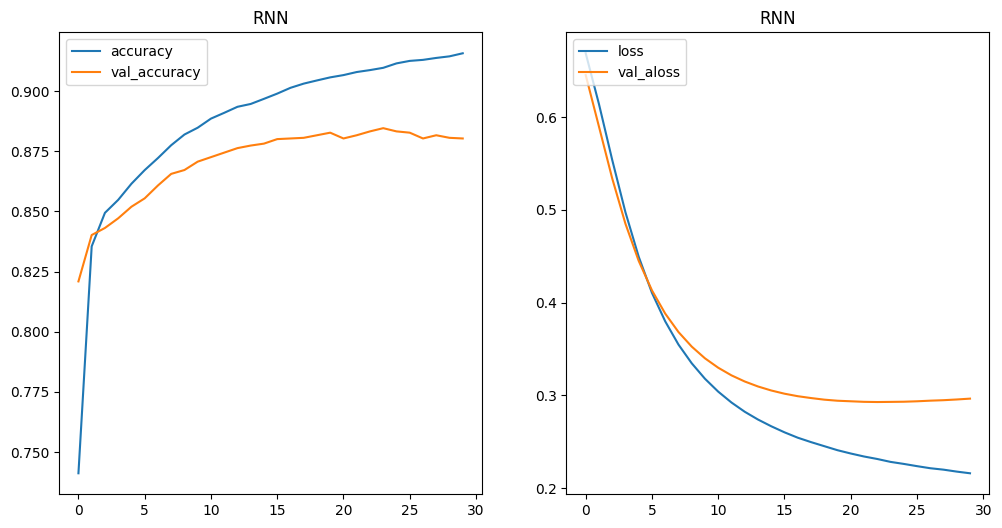

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("RNN")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("RNN")
plt.legend(loc='upper left')
plt.show()

In [22]:
# Reshape test data to 3D (batch_size, timesteps, features)
##test_tfidf_reshaped = np.expand_dims(test_tfidf.toarray(), axis=-1)
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))
# Evaluate the model
loss_rnn, accuracy_rnn = model_rnn.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Display results
print(f"Test Loss: {loss_rnn:.4f}, Test Accuracy: {accuracy_rnn:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8798 - loss: 0.2885
Test Loss: 0.2966, Test Accuracy: 0.8735


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12266
           1       0.87      0.88      0.87     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678



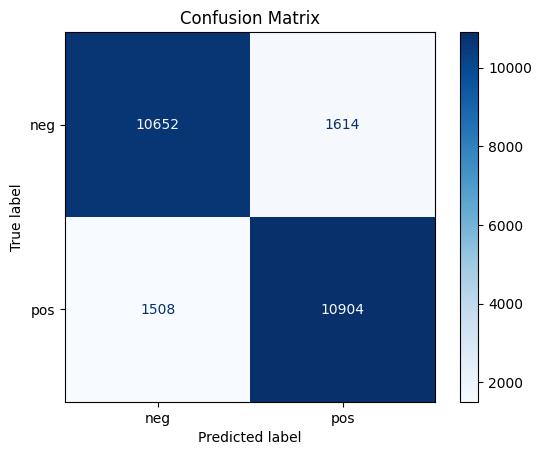

In [23]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_rnn.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [24]:
duration={}
accuracy={}

In [25]:
duration["RNN"] = time_RNN
accuracy["RNN"] = accuracy_rnn

In [26]:
duration,accuracy

({'RNN': 34.14673972129822}, {'RNN': 0.873490571975708})

### III.2 LSTM

Les LSTM sont une amélioration directe des RNN, conçus pour résoudre les problèmes de gradients disparus. Leur architecture repose sur des cellules mémoire capables de conserver des informations sur de longues périodes, grâce à trois types de portes :

+ Porte d'entrée : Détermine quelles informations de l'entrée actuelle doivent être mémorisées.
+ Porte d'oubli : Décide quelles informations existantes doivent être effacées de la cellule mémoire.
+ Porte de sortie : Contrôle quelles informations de la cellule mémoire influencent la sortie actuelle.

Cette conception permet aux LSTM de capturer efficacement des dépendances à long terme, ce qui est crucial pour des tâches comme l'analyse de sentiments, où le sentiment global peut dépendre de mots ou de phrases spécifiques dans un commentaire.

In [27]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [28]:
# Construction du modèle RNN
model_lstm = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
model_lstm.add(LSTM(128, activation='tanh',input_shape=(1, train_tfidf_dense.shape[1])))  # Première couche LSTM, return_sequences=True permet de passer les séquences à la couche suivante



# Dropout pour éviter le surapprentissage
model_lstm.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_lstm.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# Compilation du modèle
model_lstm.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])


model_lstm.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │     1,602,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,602,177 (6.11 MB)

 Trainable params: 1,602,177 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

start_time= time.time()
# Entraînement du modèle
history=model_lstm.fit(train_tfidf_dense, y_train,
          epochs=30, 
          batch_size=64, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_LSTM=end_time - start_time

Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6414 - loss: 0.6902 - val_accuracy: 0.8065 - val_loss: 0.6811
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8148 - loss: 0.6756 - val_accuracy: 0.8300 - val_loss: 0.6612
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8428 - loss: 0.6517 - val_accuracy: 0.8351 - val_loss: 0.6306
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8452 - loss: 0.6167 - val_accuracy: 0.8410 - val_loss: 0.5907
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8514 - loss: 0.5719 - val_accuracy: 0.8437 - val_loss: 0.5462
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8566 - loss: 0.5238 - val_accuracy: 0.8472 - val_loss: 0.5025
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8595 - loss: 0.4775 - val_accuracy: 0.8509 - val_loss: 0.4637
Epoch 8/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8590 - loss: 0.4397 - val_accuracy: 0.

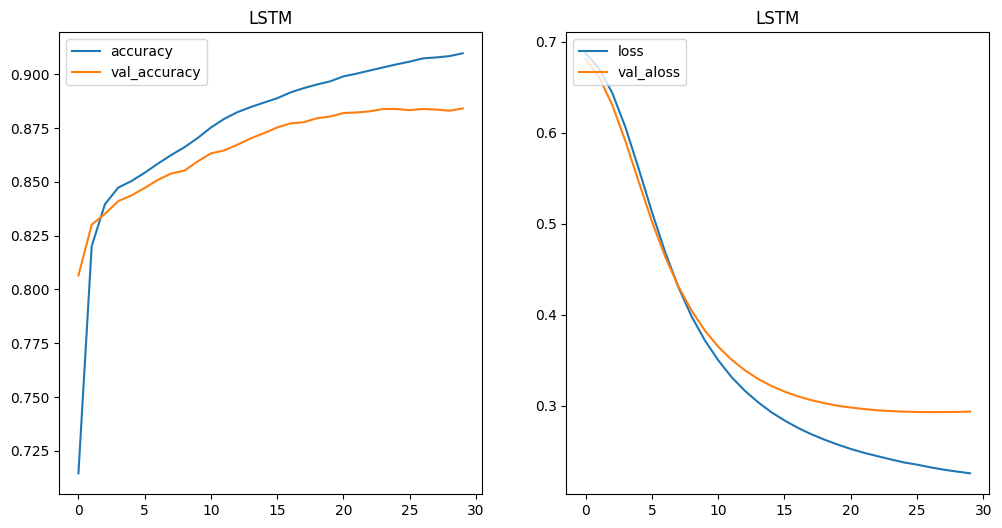

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("LSTM")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("LSTM")
plt.legend(loc='upper left')
plt.show()

In [31]:
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))

# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_LSTM, accuracy_LSTM = model_lstm.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_LSTM:.4f}, Test Accuracy: {accuracy_LSTM:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8795 - loss: 0.2927
Test Loss: 0.2920, Test Accuracy: 0.8764


In [32]:
duration["LSTM"] = time_LSTM
accuracy["LSTM"] = accuracy_LSTM

In [33]:
duration, accuracy

({'RNN': 34.14673972129822, 'LSTM': 71.87533712387085},
 {'RNN': 0.873490571975708, 'LSTM': 0.8764486312866211})

772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12266
           1       0.88      0.88      0.88     12412

    accuracy                           0.88     24678
   macro avg       0.88      0.88      0.88     24678
weighted avg       0.88      0.88      0.88     24678



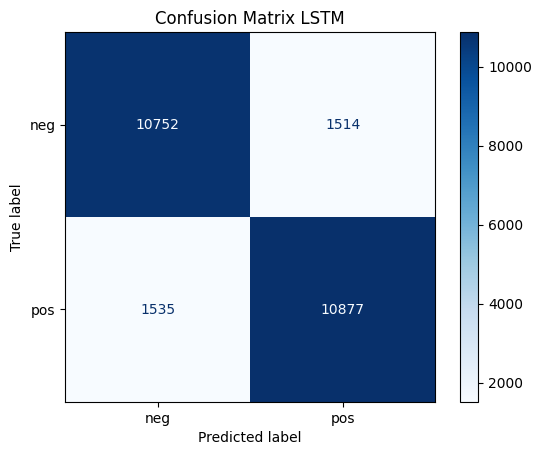

In [34]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_lstm.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix LSTM")
plt.show()

### III.3 GRU

Les GRU représentent une version simplifiée des LSTM, avec moins de paramètres et une architecture réduite. Ils utilisent deux portes principales :

+ Porte de mise à jour : Combine les fonctions des portes d'entrée et d'oubli des LSTM pour mettre à jour l'état caché.
+ Porte de réinitialisation : Contrôle la quantité d'informations précédentes à oublier.

Les GRU offrent des performances comparables à celles des LSTM sur de nombreuses tâches, tout en étant plus rapides à entraîner et moins coûteux en termes de calcul. Cela en fait un choix efficace pour des tâches où les ressources de calcul sont limitées.

In [35]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [36]:
# Construction du modèle RNN
model_gru = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
model_gru.add(GRU(128, activation='tanh',input_shape=(1, train_tfidf_dense.shape[1])))  # Première couche LSTM, return_sequences=True permet de passer les séquences à la couche suivante



# Dropout pour éviter le surapprentissage
model_gru.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_gru.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# Compilation du modèle
model_gru.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])


model_gru.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │     1,201,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,202,049 (4.59 MB)

 Trainable params: 1,202,049 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

start_time= time.time()
# Entraînement du modèle
history=model_gru.fit(train_tfidf_dense, y_train,
          epochs=30, 
          batch_size=64, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_GRU=end_time - start_time

Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6474 - loss: 0.6870 - val_accuracy: 0.8209 - val_loss: 0.6676
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8350 - loss: 0.6570 - val_accuracy: 0.8332 - val_loss: 0.6313
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8458 - loss: 0.6147 - val_accuracy: 0.8383 - val_loss: 0.5851
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8531 - loss: 0.5652 - val_accuracy: 0.8423 - val_loss: 0.5358
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8511 - loss: 0.5139 - val_accuracy: 0.8485 - val_loss: 0.4897
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8595 - loss: 0.4658 - val_accuracy: 0.8525 - val_loss: 0.4503
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8655 - loss: 0.4252 - val_accuracy: 0.8552 - val_loss: 0.4182
Epoch 8/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8729 - loss: 0.3896 - val_accuracy: 0.

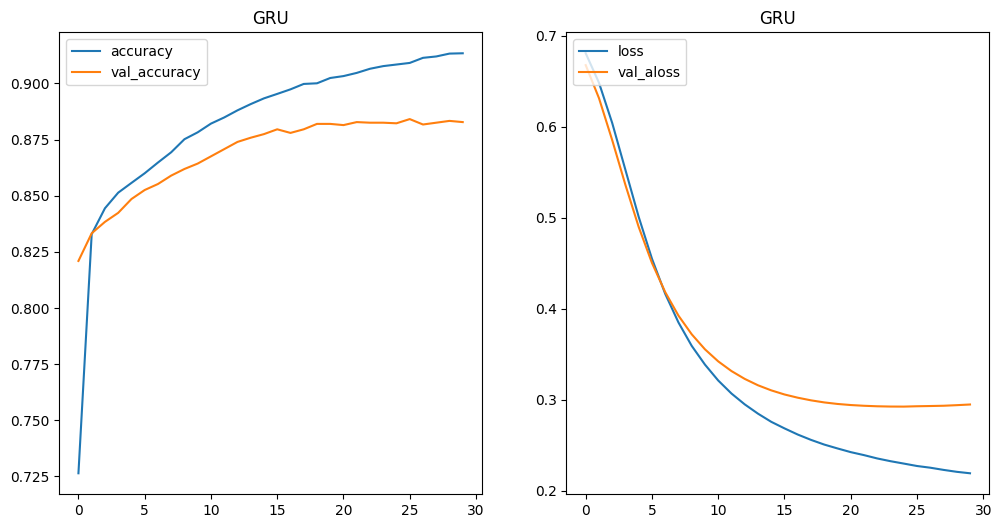

In [38]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("GRU")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("GRU")
plt.legend(loc='upper left')
plt.show()

In [39]:
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))

# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_GRU, accuracy_GRU = model_gru.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_GRU:.4f}, Test Accuracy: {accuracy_GRU:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8804 - loss: 0.2865
Test Loss: 0.2939, Test Accuracy: 0.8744


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12266
           1       0.87      0.88      0.88     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678



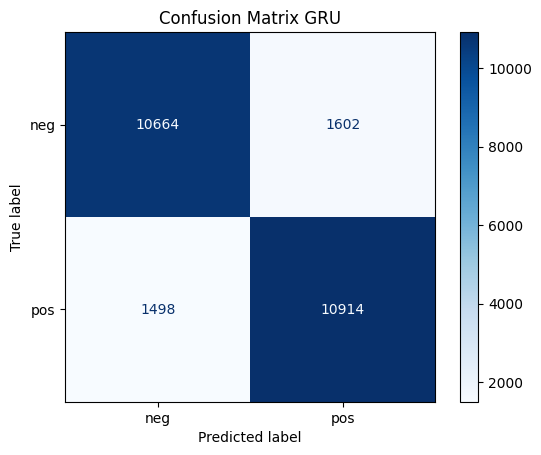

In [40]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_gru.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix GRU")
plt.show()

In [41]:
duration["GRU"] = time_GRU
accuracy["GRU"] = accuracy_GRU

### III.4 MLP

Les MLP sont des réseaux de neurones entièrement connectés qui, bien qu'initialement non adaptés aux données séquentielles, peuvent être utilisés pour des tâches comme l'analyse de sentiments via des représentations vectorielles du texte.

Avantages :

+ Simplicité de conception.

Limites :

+ Absence de mécanismes intégrés pour modéliser les dépendances séquentielles ou contextuelles.

In [42]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()
test_tfidf_dense = test_tfidf.toarray()

In [43]:
# Construction du modèle MLP
model_mlp = Sequential()

# Ajouter une couche d'entrée entièrement connectée avec 128 unités
model_mlp.add(Dense(128, activation='relu', input_dim=train_tfidf_dense.shape[1]))  # Entrée dense, avec ReLU

# Dropout pour éviter le surapprentissage
model_mlp.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_mlp.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# Compilation du modèle
model_mlp.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_mlp.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,257 (1.47 MB)

 Trainable params: 384,257 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Entraînement du modèle MLP
start_time_mlp = time.time()

history_mlp = model_mlp.fit(train_tfidf_dense, y_train,
                            epochs=30, 
                            batch_size=64, 
                            validation_data=(val_tfidf_dense, y_val), 
                            verbose=1)

end_time_mlp = time.time()

# Durée de l'entraînement
time_mlp = end_time_mlp - start_time_mlp


Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6030 - loss: 0.6886 - val_accuracy: 0.8046 - val_loss: 0.6692
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8215 - loss: 0.6547 - val_accuracy: 0.8362 - val_loss: 0.6161
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8460 - loss: 0.5953 - val_accuracy: 0.8448 - val_loss: 0.5572
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8550 - loss: 0.5331 - val_accuracy: 0.8522 - val_loss: 0.5052
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8626 - loss: 0.4805 - val_accuracy: 0.8528 - val_loss: 0.4623
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.4374 - val_accuracy: 0.8573 - val_loss: 0.4282
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8657 - loss: 0.4059 - val_accuracy: 0.8613 - val_loss: 0.4010
Epoch 8/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8755 - loss: 0.3752 - val_accuracy: 0.

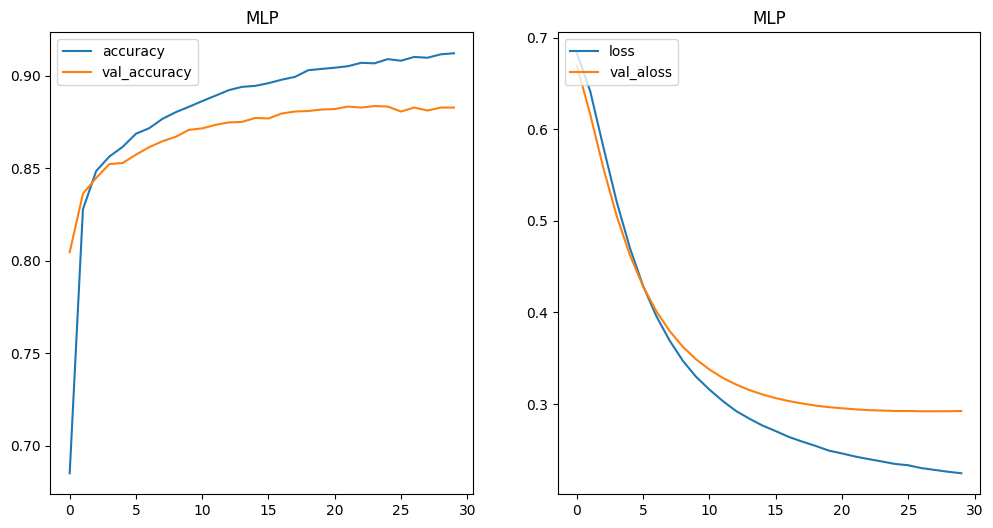

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_mlp.history['accuracy'], label='accuracy')
plt.plot(history_mlp.history['val_accuracy'], label = 'val_accuracy')
plt.title("MLP")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history_mlp.history['loss'], label='loss')
plt.plot(history_mlp.history['val_loss'], label = 'val_aloss')
plt.title("MLP")
plt.legend(loc='upper left')
plt.show()

In [46]:
# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_MLP, accuracy_MLP = model_mlp.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_MLP:.4f}, Test Accuracy: {accuracy_MLP:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8795 - loss: 0.2882
Test Loss: 0.2921, Test Accuracy: 0.8747


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12266
           1       0.87      0.88      0.88     12412

    accuracy                           0.87     24678
   macro avg       0.87      0.87      0.87     24678
weighted avg       0.87      0.87      0.87     24678



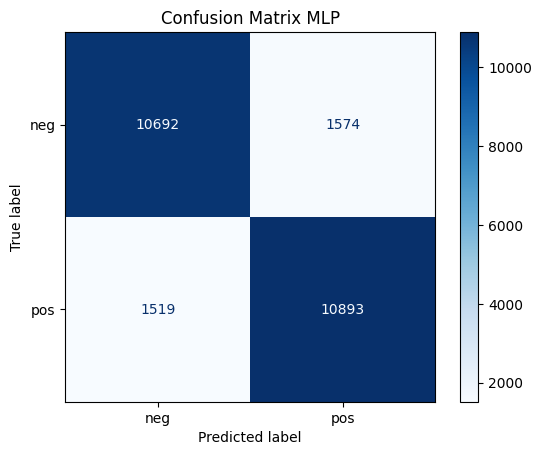

In [47]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_mlp.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix MLP")
plt.show()

In [48]:
duration["MLP"] = time_mlp
accuracy["MLP"] = accuracy_MLP

### III.5 Conv1D

Traditionnellement utilisés pour la reconnaissance d'images, les CNN peuvent également être adaptés aux données textuelles en utilisant des convolutions 1D. Dans le contexte de l'analyse de sentiments, les CNN peuvent :

+ Capturer des motifs locaux (par exemple, des n-grams) à partir de vecteurs d'embedding.
+ Identifier des structures clés dans les phrases sans dépendre de l'ordre séquentiel global.

Les CNN sont particulièrement efficaces pour extraire des caractéristiques pertinentes des séquences textuelles tout en étant rapides à entraîner. Cependant, ils manquent de mécanismes explicites pour modéliser des dépendances à long terme, contrairement aux modèles récurrents.

In [49]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [50]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
# Construction du modèle Conv1D
model_conv1d = Sequential()

# Ajouter une couche de convolution 1D
model_conv1d.add(Conv1D(64, 5, activation='relu', input_shape=(train_tfidf_dense.shape[1], 1)))  # 64 filtres, taille de noyau = 5

# Ajouter une couche de pooling pour réduire les dimensions
model_conv1d.add(MaxPooling1D(pool_size=2))  # Pooling avec une taille de 2

# Applatissement de la sortie pour la connecter à des couches denses
model_conv1d.add(Flatten())

# Dropout pour éviter le surapprentissage
model_conv1d.add(Dropout(0.2))

# Couche de sortie pour la classification binaire
model_conv1d.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# Compilation du modèle
model_conv1d.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_conv1d.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2996, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1498, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 95872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 95872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │        95,873 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,257 (376.00 KB)

 Trainable params: 96,257 (376.00 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Reshape train and validation data for Conv1D
train_tfidf_dense_reshaped = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], train_tfidf_dense.shape[1], 1))  # Adding the third dimension (1 feature per word)
val_tfidf_dense_reshaped = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], val_tfidf_dense.shape[1], 1))

# Start training the model
start_time_conv1d = time.time()

history_conv1d = model_conv1d.fit(train_tfidf_dense_reshaped, y_train,
                                  epochs=30, 
                                  batch_size=64, 
                                  validation_data=(val_tfidf_dense_reshaped, y_val), 
                                  verbose=1)

end_time_conv1d = time.time()

# Store the training time for Conv1D
time_conv1d = end_time_conv1d - start_time_conv1d


Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6644 - loss: 0.6872 - val_accuracy: 0.7915 - val_loss: 0.6670
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8070 - loss: 0.6562 - val_accuracy: 0.8035 - val_loss: 0.6284
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8175 - loss: 0.6130 - val_accuracy: 0.8057 - val_loss: 0.5853
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8216 - loss: 0.5690 - val_accuracy: 0.8057 - val_loss: 0.5443
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8233 - loss: 0.5261 - val_accuracy: 0.8078 - val_loss: 0.5094
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8297 - loss: 0.4888 - val_accuracy: 0.8126 - val_loss: 0.4809
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8325 - loss: 0.4628 - val_accuracy: 0.8148 - val_loss: 0.4573
Epoch 8/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8367 - loss: 0.4359 - val_acc

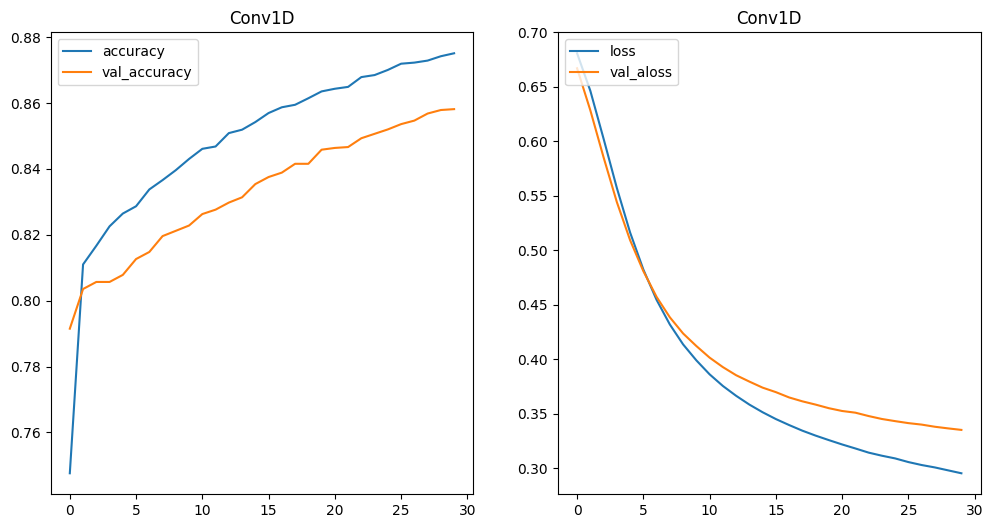

In [52]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_conv1d.history['accuracy'], label='accuracy')
plt.plot(history_conv1d.history['val_accuracy'], label = 'val_accuracy')
plt.title("Conv1D")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history_conv1d.history['loss'], label='loss')
plt.plot(history_conv1d.history['val_loss'], label = 'val_aloss')
plt.title("Conv1D")
plt.legend(loc='upper left')
plt.show()

In [53]:
# Reshape test data for Conv1D (3D)
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], test_tfidf.toarray().shape[1], 1))

# Convert labels to numpy array (if they are in pandas DataFrame)
y_test = test_df['label'].to_numpy()

# Now you can evaluate the model with the correctly shaped data
loss_conv1d, accuracy_conv1d = model_conv1d.evaluate(test_tfidf_dense, y_test, verbose=1)

# Display the results
print(f"Test Loss: {loss_conv1d:.4f}, Test Accuracy: {accuracy_conv1d:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8625 - loss: 0.3275
Test Loss: 0.3318, Test Accuracy: 0.8553


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12266
           1       0.85      0.86      0.86     12412

    accuracy                           0.86     24678
   macro avg       0.86      0.86      0.86     24678
weighted avg       0.86      0.86      0.86     24678



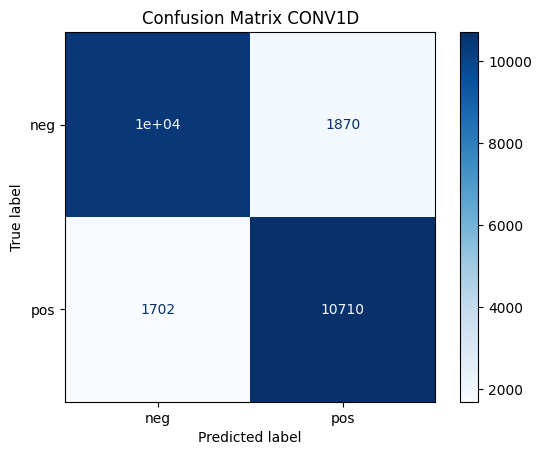

In [54]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_conv1d.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix CONV1D")
plt.show()

In [55]:
duration["CONV1D"] = time_conv1d
accuracy["CONV1D"] = accuracy_conv1d

## IV Comparaison 


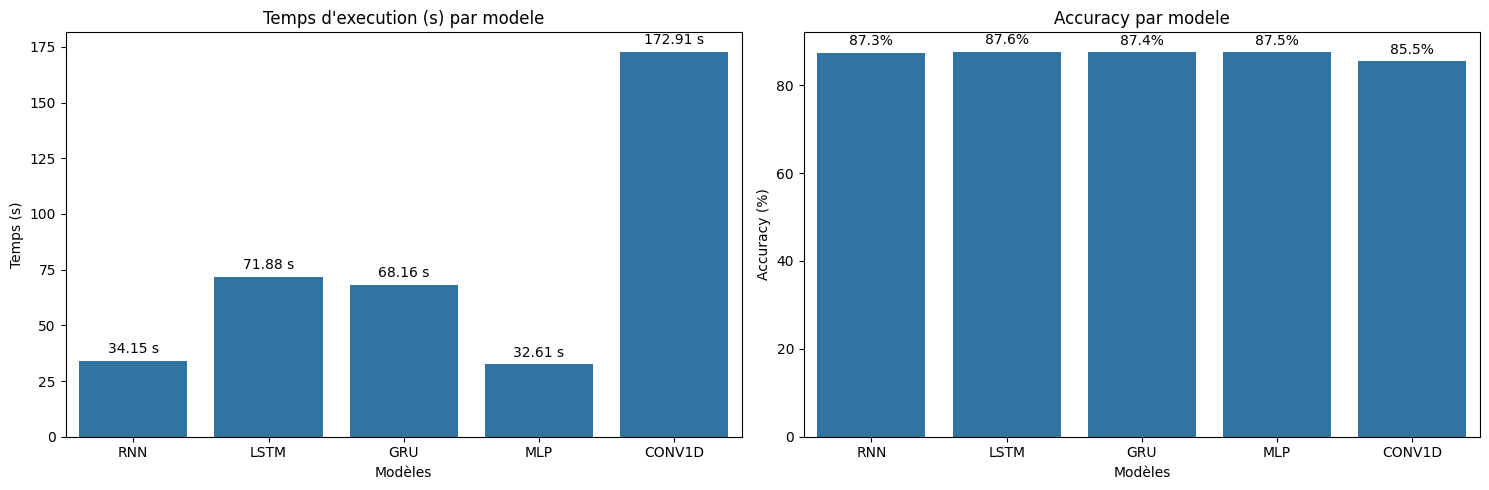

In [63]:
# Conversion des données en listes
models = list(duration.keys())  # Liste des modèles
duration_values = list(duration.values())  # Liste des valeurs de temps d'exécution
accuracy_values = [val * 100 for val in accuracy.values()]  # Conversion des valeurs de précision en pourcentage

# Création des graphiques
plt.figure(figsize=(15, 5))  # Taille de la figure

# Graphique pour le temps d'exécution
plt.subplot(121)  # Première sous-figure
ax1 = sns.barplot(x=models, y=duration_values)  # Création d'un graphique en barres pour le temps d'exécution
plt.title("Temps d'execution (s) par modele")  # Titre du graphique
plt.ylabel("Temps (s)")  # Étiquette pour l'axe Y
plt.xlabel("Modèles")  # Étiquette pour l'axe X
# Ajout des étiquettes avec les valeurs au-dessus des barres
for i, value in enumerate(duration_values):
    ax1.text(i, value + 2, f'{value:.2f} s', ha='center', va='bottom', fontsize=10)  # Affiche les valeurs avec 2 décimales et "s"

# Graphique pour la précision
plt.subplot(122)  # Deuxième sous-figure
ax2 = sns.barplot(x=models, y=accuracy_values)  # Création d'un graphique en barres pour la précision
plt.title("Accuracy par modele")  # Titre du graphique
plt.ylabel("Accuracy (%)")  # Étiquette pour l'axe Y
plt.xlabel("Modèles")  # Étiquette pour l'axe X
# Ajout des étiquettes avec les valeurs au-dessus des barres
for i, value in enumerate(accuracy_values):
    ax2.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)  # Affiche les valeurs en pourcentage avec 1 décimale

# Affichage des graphiques
plt.tight_layout()  # Ajuste automatiquement l'espacement entre les sous-graphes
plt.show()  # Affiche les graphiques

+ Nous observons que la différence d'accuracy entre les modèles est négligeable, sauf pour le réseau CONV1D qui présente une légère baisse. Cela peut être expliqué par le fait que nous avons utilisé uniquement une seule couche CNN pour extraire les informations. Quant au MLP, il fonctionne relativement bien, parce que la qualité de la préparation des données d'entrée sous forme de vecteurs est suffisamment bonne pour atteindre l'objectif fixé. En expérimentant différentes méthodes de préparation et de présentation des textes, nous avons constaté que l'accuracy dépend principalement de la qualité de notre traitement des textes.

+ En ce qui concerne le temps d'exécution, nous voyons, comme prévu théoriquement, que le LSTM a le temps d'exécution le plus long. Cela s'explique par le fait qu'à chaque nœud, il passe par trois ports différents, ce qui est compréhensible. Le GRU, étant une version simplifiée du LSTM, a un temps d'exécution plus court. Cependant, il dispose de deux ports, ce qui le rend plus complexe que le RNN simple. Par conséquent, son temps d'exécution est également plus long que celui du RNN simple. Pour le MLP, il est probablement optimisé pour un traitement parallèle et ne contient qu'une seule couche, ce qui explique son temps d'exécution relativement faible. Enfin, le modèle CONV1D utilise de nombreux filtres, ce qui augmente le temps nécessaire à l'entraînement.

## V. Assemblage des modeles

In [81]:
from sklearn.metrics import accuracy_score

# Assuming `model_rnn`, `model_lstm`, `model_gru`, `model_conv1d`, and `model_mlp`
# have been trained and the corresponding test data is available
test_tfidf_dense_rnn = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))
test_tfidf_dense_mlp = test_tfidf.toarray()
test_tfidf_dense_conv = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], test_tfidf.toarray().shape[1], 1))
# Step 1: Make predictions for each model
y_pred_rnn = (model_rnn.predict(test_tfidf_dense_rnn) > 0.5).astype(int)
y_pred_lstm = (model_lstm.predict(test_tfidf_dense_rnn) > 0.5).astype(int)
y_pred_gru = (model_gru.predict(test_tfidf_dense_rnn) > 0.5).astype(int)
y_pred_mlp = (model_mlp.predict(test_tfidf_dense_mlp) > 0.5).astype(int)
y_pred_conv1d = (model_conv1d.predict(test_tfidf_dense_conv) > 0.5).astype(int)


772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


0.87446308452873


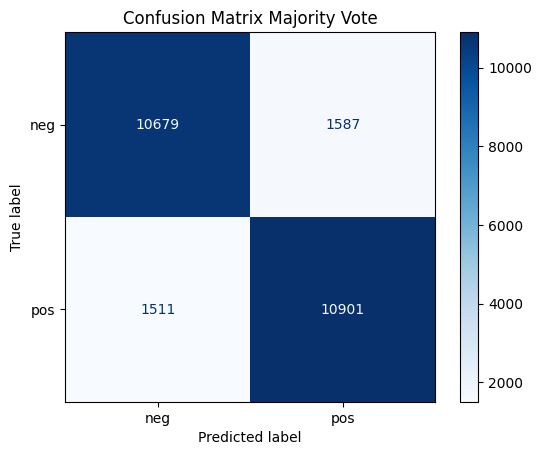

In [82]:
# Stack predictions from all models
predictions_stack = np.stack([y_pred_rnn, y_pred_lstm, y_pred_gru, y_pred_conv1d, y_pred_mlp], axis=0)

# Apply majority voting (mode of the predictions)
# Each row corresponds to one test sample, and the majority vote is calculated across the models
ensemble_predictions = np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_stack))

# Evaluate the ensemble
accuracy_ensemble = accuracy_score(test_df['label'], ensemble_predictions)

print(accuracy_ensemble) 

# Confusion matrix
cm = confusion_matrix(test_df['label'], ensemble_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Majority Vote")
plt.show()



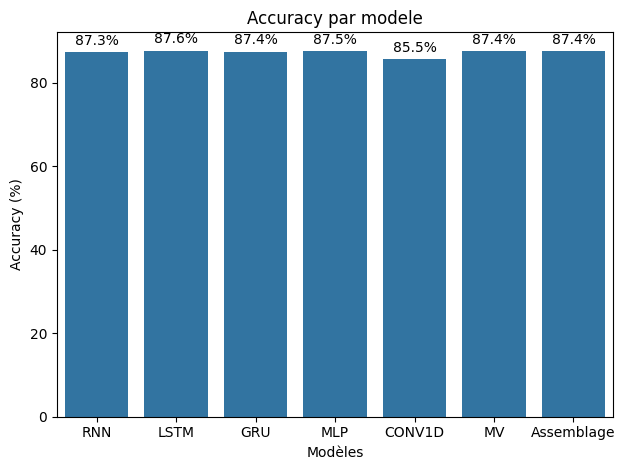

In [88]:
# Ajouter la valeur de l'ensemble (ensemble accuracy) au dictionnaire accuracy
accuracy["MV"] = accuracy_ensemble  # "MV" représente la précision de la méthode de vote majoritaire (Majority Voting)

# Mettre à jour la liste des modèles pour inclure "MV"
models = list(accuracy.keys())  # Extraire les clés du dictionnaire accuracy pour les utiliser comme noms de modèles
accuracy_values = [val * 100 for val in accuracy.values()]  # Convertir les valeurs de précision en pourcentages

# Créer le graphique en barres
ax = sns.barplot(x=models, y=accuracy_values)  # Tracer les barres pour chaque modèle
plt.title("Accuracy par modele")  # Ajouter le titre du graphique
plt.ylabel("Accuracy (%)")  # Ajouter une étiquette à l'axe Y (en pourcentage)
plt.xlabel("Modèles")  # Ajouter une étiquette à l'axe X (noms des modèles)

# Ajouter les étiquettes des valeurs au-dessus des barres
for i, value in enumerate(accuracy_values):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)  # Afficher les valeurs (avec une décimale) au-dessus des barres

# Ajuster l'affichage des graphiques
plt.tight_layout()  # Optimiser l'espacement entre les éléments du graphique
plt.show()  # Afficher le graphique

Conclusion :
+ Ce que nous avons réalisé et appris à travers ce projet :

    + Exploration et traitement des données (valeurs manquantes, doublons) ainsi que la représentation des textes en utilisant un vectoriseur.
    + Choix des hyperparamètres comme le nombre d’époques, la taille de batch et le taux d’apprentissage pour optimiser le temps d’entraînement des modèles.
    + Construction de modèles de prédiction assez performants (~88%) pour atteindre l’objectif du projet.
    + Comparaison des temps d’exécution des modèles, avec le temps du RNN inférieur à celui du GRU, lui-même inférieur à celui du LSTM, ce qui dépend de la complexité des nœuds dans ces modèles.
    + Pour des textes pas trop longs, l’accuracy des modèles n’a pas une grande différence ; elle dépend principalement de la qualité de la représentation textuelle.